In [7]:
# !pip install yfinance tensorflow keras numpy matplotlib seaborn tqdm scikit-learn graphviz

In [24]:
from utils import *
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import plotly.graph_objects as go

sns.set()

# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [25]:
# stock configs
ticker = ['TSLA']
start_date = '2015-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30  # Number of past days we want to use to predict the future.

In [26]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2268, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-04-01,12.580000,12.820000,12.403333,12.506000,56919000,0.0,0.0
1,2015-04-02,12.682000,12.882000,12.666667,12.733333,75156000,0.0,0.0
2,2015-04-06,13.200000,13.850000,13.166667,13.540000,186837000,0.0,0.0
3,2015-04-07,13.500667,13.670667,13.409333,13.550000,65218500,0.0,0.0
4,2015-04-08,13.880000,14.060000,13.724667,13.844667,94546500,0.0,0.0


# Model Implementation

Below we implement the model, first we separate the data into a train-test split.  For this LSTM model, we will leverage continuous windows of time for training and test data.


In [27]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Create input sequences
lookback = 30
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, 3])  # Closing price is at index 3
X, y = np.array(X), np.array(y)
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Add an explicit Input layer
model.add(LSTM(units=50, return_sequences=True))              # No need to include input_shape here
model.add(Dropout(0.2))
model.add(LSTM(units=50))                                     # Second LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=1))                                     # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')    # Compile the model
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0182
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0018
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015


In [28]:
# Specify the number of iterations
num_iterations = 5

# Create traces for actual and predicted stock prices
trace_actual = go.Scatter(
    x=data['Date'][train_size+lookback:],
    y=data['Close'][train_size+lookback:],
    mode='lines',
    name='Actual Price',
    line=dict(color='blue')
)

traces_predicted = []
for i in range(num_iterations):
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Inverse transform the scaled data
    y_pred_inverse = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), np.zeros_like(y_pred), np.zeros_like(y_pred), y_pred, np.zeros_like(y_pred))))[:, 3]

    # Create a trace for each iteration
    trace_predicted = go.Scatter(
        x=data['Date'][train_size+lookback:],
        y=y_pred_inverse,
        mode='lines',
        name=f'Predicted Price (Iteration {i+1})',
        line=dict(color=f'rgba(255, 0, 0, {0.2 + i*0.2})', dash='dot')
    )
    traces_predicted.append(trace_predicted)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7103e-04
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3961e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.9063e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4365e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9959e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0937e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.4833e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8664e-04
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.4418e-04
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.8808e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1879e-04
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.3566e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.5774e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

In [29]:
# Create the layout
layout = go.Layout(
    title='Stock Price Prediction (Multiple Iterations)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template='plotly_dark'
)

# Create the figure and display it
fig = go.Figure(data=[trace_actual] + traces_predicted, layout=layout)
fig.show()

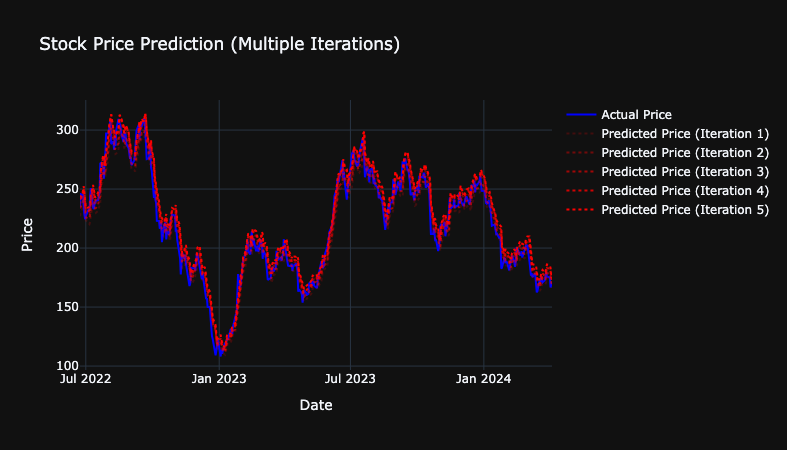